# Impact of single-atom changes on similarity

Last week I got curious about the impact single atoms make on the similarity between two molecules. I was initially wondering whether small differences in the "core" of two molecules have a disproportionate influence on the similarity between them. This blog post came from me trying to answer that question.

Along the way I discovered that there's more to this topic than I thought, so the blog post is longer than planned; and it still feels like there's some exploration to do, so I may still end up doing a follow up.

Here's a summary of the analysis of the average Tanimoto similarity of a molecule to itself with a single atom changed to a dummy atom. The analysis was done across 5000 ChEMBL molecules.

| FP  | mean(SD)   | 90%  | 95%  |
|-----|------------|------|------|
|MFP3 | 0.68(0.12) | 0.53 | 0.48 |
|MFP2 | 0.75(0.09) | 0.63 | 0.59 |
|MFP1 | 0.83(0.06) | 0.75 | 0.72 |
|RDK7 | 0.76(0.15) | 0.54 | 0.47 |
|RDK5 | 0.74(0.14) | 0.53 | 0.46 |
|TT   | 0.78(0.12) | 0.61 | 0.55 |
|AP   | 0.88(0.05) | 0.83 | 0.81 |

We can think about these values as thresholds for retrieving *extremely* similar molecules: using the RDK5 fingerprint (RDKit fingerprint with a path length of 5) we need to use a Tanimoto similarity threshold of 0.46 to be 95% certain of retrieving molecules that have the same connectivity and that only differ in the identity of a single atom.

As for my original question about centrality: it's not how central an atom is that matters, but how many atoms are close to it. We can see this in the similarity map showing the contributions of individual atoms to the similarity of one of the test molecules to itself using the RDK5 fingerprint:

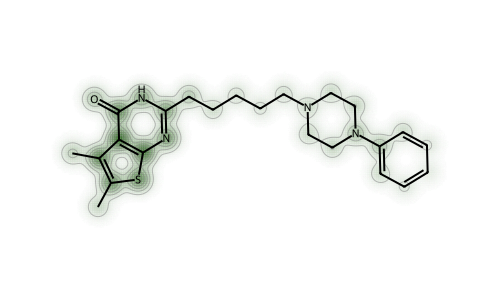

In [1]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import Draw
from rdkit import DataStructs
from rdkit import RDLogger
import numpy as np


from matplotlib import pyplot as plt
plt.style.use('tableau-colorblind10')
plt.rcParams['font.size'] = '16'

%matplotlib inline

import rdkit
print(rdkit.__version__)

2024.03.2


Let's start with one of my favority example molecules, the bioactive part of esomeprazole:

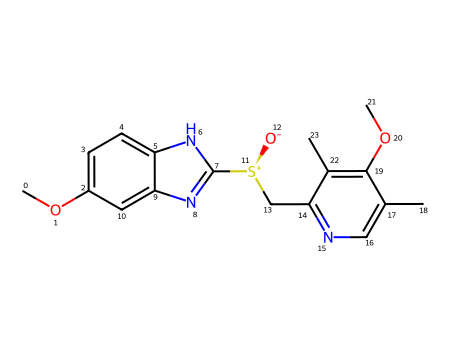

In [2]:
IPythonConsole.molSize = 450,350
IPythonConsole.drawOptions.addAtomIndices = True
esomeprazole = Chem.MolFromSmiles('COc1ccc2[nH]c(nc2c1)[S@@+]([O-])Cc3ncc(C)c(OC)c3C')
esomeprazole

Define a function which changes each of the atoms to a dummy and then compares the similarity of that to the unperturbed molecule.

We track the similarity between the modified and original molecules together with the number of atoms within a target radius of the modified atom (this second piece of info will be used at the end of the blog post).


In [3]:
def get_modified_sims(mol,maxRadius,fpFunc):
    basefp = fpFunc(mol)
    dm = Chem.GetDistanceMatrix(mol)
    res = []
    for aidx in range(mol.GetNumAtoms()):
        nm = Chem.Mol(mol)
        nm.GetAtomWithIdx(aidx).SetAtomicNum(0)
        count = sum(dm[aidx]<=maxRadius)
        res.append((count,DataStructs.TanimotoSimilarity(basefp,fpFunc(nm))))
    return res

Now run that for esomeprazole using Morgan fingerprints with three different radius values.

We do the analysis for both count-based and bit-based fingerprints

In [4]:
from collections import defaultdict
res = defaultdict(lambda : defaultdict(list))

for radius in (1,2,3):
    fpg = rdFingerprintGenerator.GetMorganGenerator(radius=radius,fpSize=2048)
    res['counts'][radius].extend(get_modified_sims(esomeprazole,radius,fpg.GetCountFingerprint))
    res['bits'][radius].extend(get_modified_sims(esomeprazole,radius,fpg.GetFingerprint))
    

At each radius value, there's one entry in `res` for each atom in the molecule:

In [5]:
print(esomeprazole.GetNumAtoms(),len(res['counts'][3]))

24 24


Here are the values:

In [6]:
res['counts'][3]

[(5, 0.8260869565217391),
 (7, 0.7319587628865979),
 (9, 0.6470588235294118),
 (9, 0.68),
 (10, 0.6310679611650486),
 (10, 0.5849056603773585),
 (11, 0.6),
 (11, 0.5849056603773585),
 (11, 0.6),
 (11, 0.5700934579439252),
 (11, 0.6153846153846154),
 (11, 0.6),
 (7, 0.75),
 (12, 0.6153846153846154),
 (12, 0.6),
 (10, 0.6470588235294118),
 (9, 0.68),
 (10, 0.6633663366336634),
 (7, 0.7684210526315789),
 (11, 0.6470588235294118),
 (9, 0.7319587628865979),
 (5, 0.8260869565217391),
 (12, 0.6153846153846154),
 (8, 0.75)]

Interpreting the above:
- atom 0 of esomeprazole has 5 atoms (including itself) within radius 2. The count-based fingerprint calculated when setting atom 0 to be a dummy has a similarity of 0.826 to the unmodified fingerprint.
- atom 22 (the second to last atom) has 12 atoms (including itself) within radius 2. The count-based fingerprint calculated when setting atom 22 to be a dummy has a similarity of 0.615 to the unmodified fingerprint.

Now let's do that perturbation on a bunch of molecules and see what the statistics look like. We'll use 5000 molecules from [this older blog post](https://rdkit.blogspot.com/2019/10/a-new-lessel-and-briem-like-dataset.html)

In [7]:
with open('../data/BLSets_actives.txt','r') as inf:
    d = [x.split('\t')[0] for x in inf.readlines()]
    d.pop(0) # title line
import random
random.seed(0xf00d)
random.shuffle(d)
d = d[:5000]

RDLogger.DisableLog('rdApp.info')
mols = []
for smi in d:
    mol = Chem.MolFromSmiles(smi)
    mols.append(mol)
rdMolStandardize.ChargeParentInPlace(mols,numThreads=4)
    

The first few molecules, just to get a sense of what we're dealing with here.

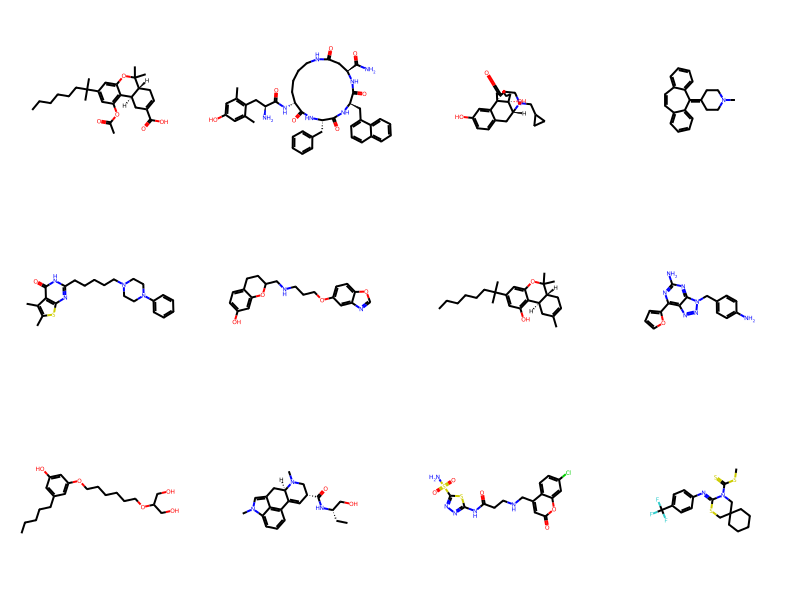

In [8]:
IPythonConsole.drawOptions.addAtomIndices = False
Draw.MolsToGridImage(mols[:12],molsPerRow=4)

Histogram of molecule sizes:

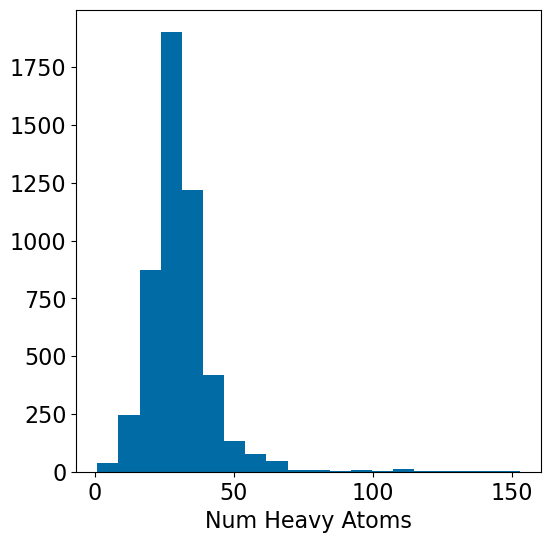

In [74]:
nAts = [x.GetNumHeavyAtoms() for x in mols]
plt.figure(figsize=(6,6))
plt.hist(nAts,bins=20);
plt.xlabel('Num Heavy Atoms');

There's a reasonable amount of computation to be done here, so we'll use ipyparallel

In [10]:
try:
    import ipyparallel as ipp
    rc = ipp.Client()
    dview = rc[:]
    dview.execute('from rdkit import Chem')
    dview.execute('from rdkit.Chem import rdFingerprintGenerator')
    dview.execute('from rdkit import DataStructs')
except:
    print("could not use ipyparallel")
    dview = None

In [11]:
def get_modified_sims2(mol,maxRadius,fpgFunc,method):
    fpg = fpgFunc()
    fpFunc = getattr(fpg,method)
    basefp = fpFunc(mol)
    dm = Chem.GetDistanceMatrix(mol)
    res = []
    for aidx in range(mol.GetNumAtoms()):
        nm = Chem.Mol(mol)
        nm.GetAtomWithIdx(aidx).SetAtomicNum(0)
        count = sum(dm[aidx]<=maxRadius)
        res.append((count,DataStructs.TanimotoSimilarity(basefp,fpFunc(nm))))
    return res

Run Morgan fingerprints with radius 1, 2, and 3.

In [66]:
accum = defaultdict(lambda : defaultdict(list))

for radius in (1,2,3):
    fpg = lambda r=radius:rdFingerprintGenerator.GetMorganGenerator(radius=r,fpSize=2048)
    lres = dview.map_sync(lambda x,r=radius,y=get_modified_sims2,
                          z=fpg:y(x,r,z,'GetCountFingerprint'),mols)
    for entry in lres:
        accum['counts'][radius].extend(entry)
    lres = dview.map_sync(lambda x,r=radius,y=get_modified_sims2,
                          z=fpg:y(x,r,z,'GetFingerprint'),mols)
    for entry in lres:
        accum['bits'][radius].extend(entry)


Run RDKit fingerprints with max path length 5, 6, and 7

In [67]:
rdkit_accum = defaultdict(lambda : defaultdict(list))

for radius in (5,6,7):
    fpg = lambda r=radius:rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=r,fpSize=2048)
    lres = dview.map_sync(lambda x,r=radius,y=get_modified_sims2,
                          z=fpg:y(x,r,z,'GetCountFingerprint'),mols)
    for entry in lres:
        rdkit_accum['counts'][radius].extend(entry)
    lres = dview.map_sync(lambda x,r=radius,y=get_modified_sims2,
                          z=fpg:y(x,r,z,'GetFingerprint'),mols)
    for entry in lres:
        rdkit_accum['bits'][radius].extend(entry)


Same analysis for topological torsions and atom pairs. For these the extra "radius" argument does not really mean anything

In [70]:
tt_accum = defaultdict(lambda : defaultdict(list))

for radius in (3,):
    fpg = lambda r=radius:rdFingerprintGenerator.GetTopologicalTorsionGenerator(fpSize=4096)
    lres = dview.map_sync(lambda x,r=radius,y=get_modified_sims2,
                          z=fpg:y(x,r,z,'GetCountFingerprint'),mols)
    for entry in lres:
        tt_accum['counts'][radius].extend(entry)
    lres = dview.map_sync(lambda x,r=radius,y=get_modified_sims2,
                          z=fpg:y(x,r,z,'GetFingerprint'),mols)
    for entry in lres:
        tt_accum['bits'][radius].extend(entry)


In [71]:
ap_accum = defaultdict(lambda : defaultdict(list))

for radius in (3,):
    fpg = lambda r=radius:rdFingerprintGenerator.GetAtomPairGenerator(fpSize=4096)
    lres = dview.map_sync(lambda x,r=radius,y=get_modified_sims2,
                          z=fpg:y(x,r,z,'GetCountFingerprint'),mols)
    for entry in lres:
        ap_accum['counts'][radius].extend(entry)
    lres = dview.map_sync(lambda x,r=radius,y=get_modified_sims2,
                          z=fpg:y(x,r,z,'GetFingerprint'),mols)
    for entry in lres:
        ap_accum['bits'][radius].extend(entry)


Save all of those results for later analysis

In [125]:
import copy
def to_dict(dd):
    if not isinstance(dd,defaultdict):
        return copy.deepcopy(dd)
    res = {}
    for k,v in dd.items():
        res[k] = to_dict(v)
    return res

In [126]:
import pickle
import gzip
with gzip.open('./results/fp_perturbation.pkl.gz','wb+') as outf:
    pickle.dump((to_dict(accum),to_dict(rdkit_accum),to_dict(ap_accum),to_dict(tt_accum)),outf)

In [159]:
!chmod gou-w ./results/fp_perturbation.pkl.gz

Load the saved data:

In [158]:
from collections import defaultdict
import pickle
import gzip
with gzip.open('./results/fp_perturbation.pkl.gz','rb') as inf:
    accum,rdkit_accum,ap_accum,tt_accum = pickle.load(inf)

Now let's look at the Morgan and RDKit results:

---- counts ----
  r=3 mean=0.74 stddev=0.10 median=0.74 90%=0.61, 95%:0.56
  r=2 mean=0.80 stddev=0.08 median=0.80 90%=0.71, 95%:0.67
  r=1 mean=0.87 stddev=0.05 median=0.88 90%=0.82, 95%:0.80
---- bits ----
  r=3 mean=0.68 stddev=0.12 median=0.69 90%=0.53, 95%:0.48
  r=2 mean=0.75 stddev=0.09 median=0.76 90%=0.63, 95%:0.59
  r=1 mean=0.83 stddev=0.06 median=0.84 90%=0.75, 95%:0.72


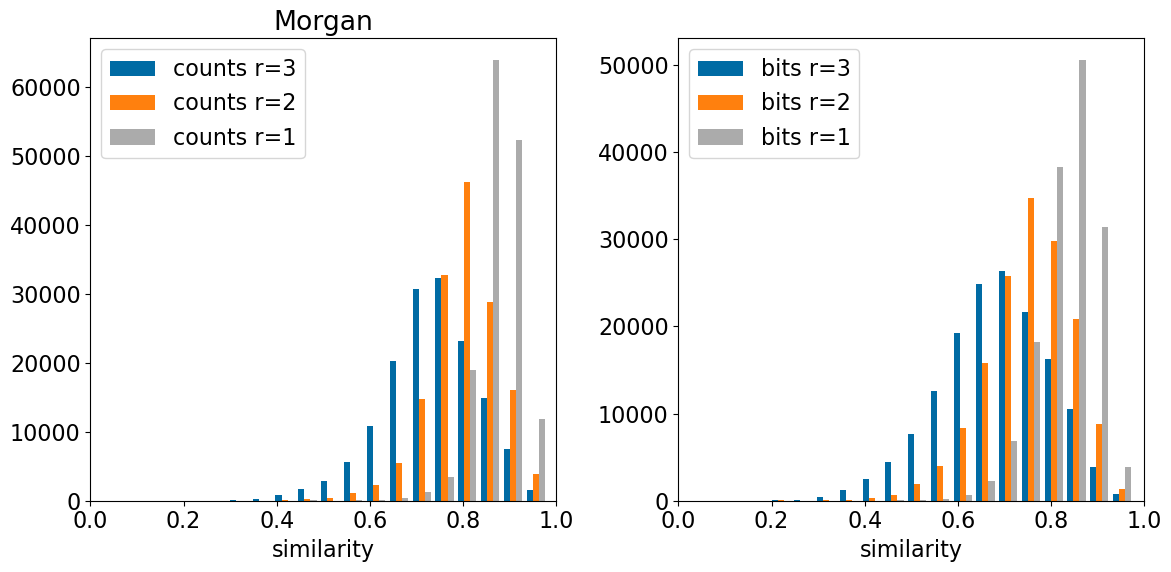

In [4]:
rs = (3,2,1)
tacc = accum
titl='Morgan'

for which in ('counts','bits'):
    print(f'---- {which} ----')
    for rad in rs:
        yps = [y for x,y in tacc[which][rad]]
        qs = np.quantile(yps,[0.1,0.05])
        print(f'  r={rad} mean={np.mean(yps):.2f} stddev={np.std(yps):.2f} median={np.median(yps):.2f} 90%={qs[0]:.2f}, 95%:{qs[1]:.2f}')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)

plt.hist([[y for x,y in tacc['counts'][rad]] for rad in rs],
         label=[f'counts r={rad}' for rad in rs],bins=20);
plt.xlabel('similarity')
plt.legend();
plt.title(titl)
plt.xlim(0,1)
plt.subplot(1,2,2)
plt.hist([[y for x,y in tacc['bits'][rad]] for rad in rs],
         label=[f'bits r={rad}' for rad in rs],bins=20);
plt.xlabel('similarity')
plt.legend();
plt.xlim(0,1)
plt.tight_layout()

Observations here:
 - The perturbations have a larger effect when the radius is larger. This makes sense because more atoms "feel" the changed atom with a larger radius.
 - I'm surprised by how large the overall impact on similarity is for these single atom-changes. With bit-based radius 2 or 3 fingerprints (the most commonly used, I believe), the mean similarities are 0.75 or 0.68 and you have to go all the way down to a similarity level of 0.59 or 0.48 to get 95% of the molecules. Those values are 0.56 and 0.67 with count-based fingerprints.

---- counts ----
  maxp=7 mean=0.71 stddev=0.17 median=0.73 90%=0.47, 95%:0.40
  maxp=6 mean=0.72 stddev=0.16 median=0.75 90%=0.50, 95%:0.42
  maxp=5 mean=0.75 stddev=0.14 median=0.77 90%=0.55, 95%:0.48
---- bits ----
  maxp=7 mean=0.76 stddev=0.15 median=0.78 90%=0.54, 95%:0.47
  maxp=6 mean=0.74 stddev=0.15 median=0.76 90%=0.52, 95%:0.45
  maxp=5 mean=0.74 stddev=0.14 median=0.76 90%=0.53, 95%:0.46


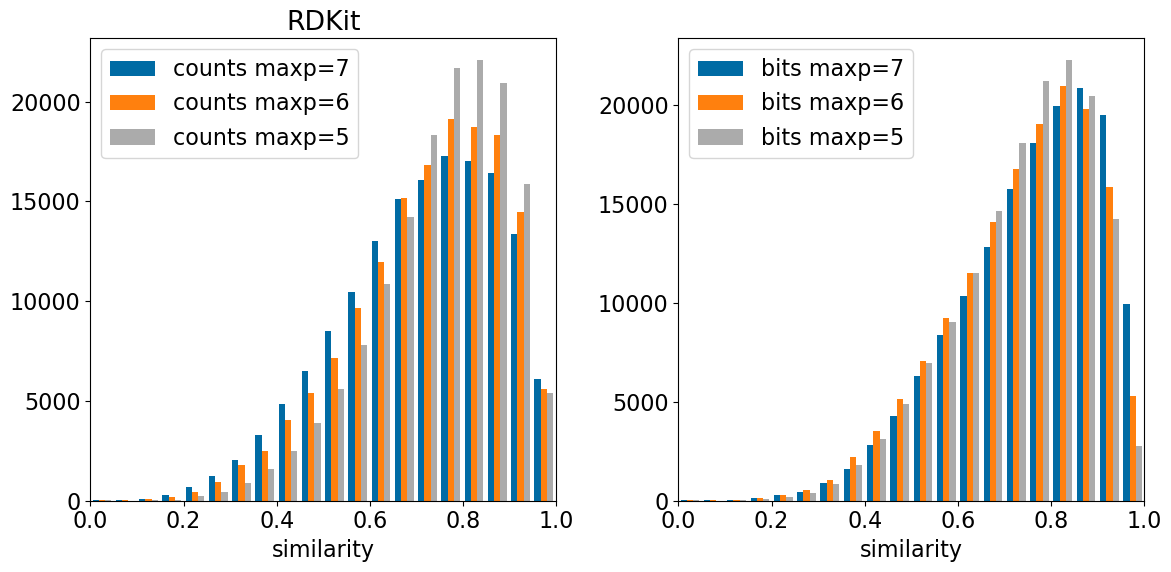

In [5]:
rs = (7,6,5)
tacc = rdkit_accum
titl='RDKit'

for which in ('counts','bits'):
    print(f'---- {which} ----')
    for rad in rs:
        yps = [y for x,y in tacc[which][rad]]
        qs = np.quantile(yps,[0.1,0.05])
        print(f'  maxp={rad} mean={np.mean(yps):.2f} stddev={np.std(yps):.2f} median={np.median(yps):.2f} 90%={qs[0]:.2f}, 95%:{qs[1]:.2f}')


plt.figure(figsize=(12,6))
plt.subplot(1,2,1)

plt.hist([[y for x,y in tacc['counts'][rad]] for rad in rs],
         label=[f'counts maxp={rad}' for rad in rs],bins=20);
plt.xlabel('similarity')
plt.legend();
plt.title(titl)
plt.xlim(0,1)
plt.subplot(1,2,2)
plt.hist([[y for x,y in tacc['bits'][rad]] for rad in rs],
         label=[f'bits maxp={rad}' for rad in rs],bins=20);
plt.xlabel('similarity')
plt.xlim(0,1)
plt.legend();
plt.tight_layout()

Observations:
  - In contrast to the Morgan fingerprints, the changes for the bit-based fingerprints are less than count-based. I assume that this has to do with collisions, the RDKit fingerprints [set way more bits](https://greglandrum.github.io/rdkit-blog/posts/2021-07-06-number-of-fp-bits-set.html) than the Morgan fingerprints and have [many more collisions](https://greglandrum.github.io/rdkit-blog/posts/2023-01-23-colliding-bits-iii-expanded.html).
  - The distributions here have much longer tails than the Morgan FPs did and are more asymmetric (this is inevitable with the longer tails).

Atom pairs and topological torsions;

---- counts ----
  TT mean=0.78 stddev=0.12 median=0.79 90%=0.61, 95%:0.55
  AP mean=0.88 stddev=0.04 median=0.88 90%=0.83, 95%:0.81
---- bits ----
  TT mean=0.78 stddev=0.12 median=0.80 90%=0.61, 95%:0.55
  AP mean=0.88 stddev=0.05 median=0.89 90%=0.83, 95%:0.81


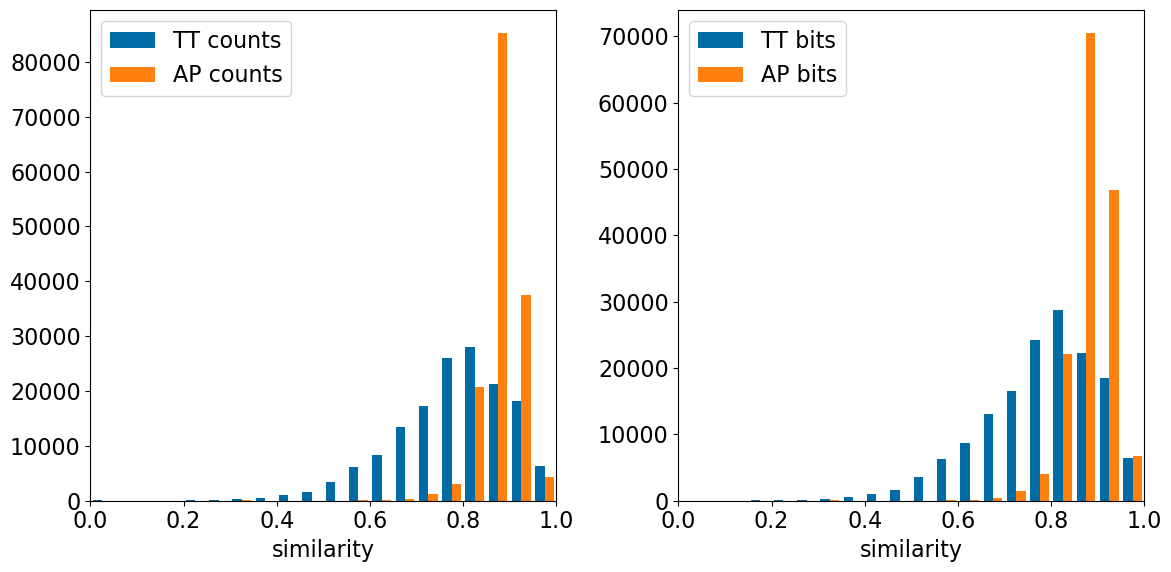

In [6]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)

for which in ('counts','bits'):
    print(f'---- {which} ----')
    yps = [y for x,y in tt_accum[which][3]]
    qs = np.quantile(yps,[0.1,0.05])
    print(f'  TT mean={np.mean(yps):.2f} stddev={np.std(yps):.2f} median={np.median(yps):.2f} 90%={qs[0]:.2f}, 95%:{qs[1]:.2f}')
    yps = [y for x,y in ap_accum[which][3]]
    qs = np.quantile(yps,[0.1,0.05])
    print(f'  AP mean={np.mean(yps):.2f} stddev={np.std(yps):.2f} median={np.median(yps):.2f} 90%={qs[0]:.2f}, 95%:{qs[1]:.2f}')


plt.hist([[y for x,y in tt_accum['counts'][3]],[y for x,y in ap_accum['counts'][3]]],
         label=[f'TT counts','AP counts'],bins=20);
plt.xlabel('similarity')
plt.xlim(0,1)
plt.legend();
plt.subplot(1,2,2)
plt.hist([[y for x,y in tt_accum['bits'][3]],[y for x,y in ap_accum['bits'][3]]],
         label=[f'TT bits','AP bits'],bins=20);
plt.xlabel('similarity')
plt.xlim(0,1)
plt.legend();
plt.tight_layout()

Observations:
 - The AP fingerprints are substantially less sensitive to the single-atom perturbations than any of the fingerprints looked at here.
 - The differences between counts and bits here are so small because both the TT and AP fingerprints use [count simulation](https://greglandrum.github.io/rdkit-blog/posts/2021-07-06-simulating-counts.html) by default (this is why I used 4096 bits here instead of the 2048 bits used for the other fingerprints)

### Aside

Assuming no collisions, we can directly calculate the atom-pair similarity between a molecule and itself with a single atom perturbed.

The Tanimoto similarity between fingerprints A and B is calculated as:

$$\frac{\|A\&B\|}{\|A\|+\|B\|-\|A\&B\|}$$

The number of atom pair bits for a molecule is:

$$\frac{N (N-1)}{2}$$

When we perturb one atom, this changes $N-1$ of those bits, so the number of bits in common between the perturbed and unperturbed fingerprints is:

$$\frac{N (N-1)}{2} - (N-1)$$

After a bit of math, we find that the Tanimoto similarity between the perturbed and unperturbed molecules is:

$$\frac{\frac{N (N-1)}{2} - (N-1)}{\frac{N (N-1)}{2} + (N-1)}$$



Plot this to demonstrate:

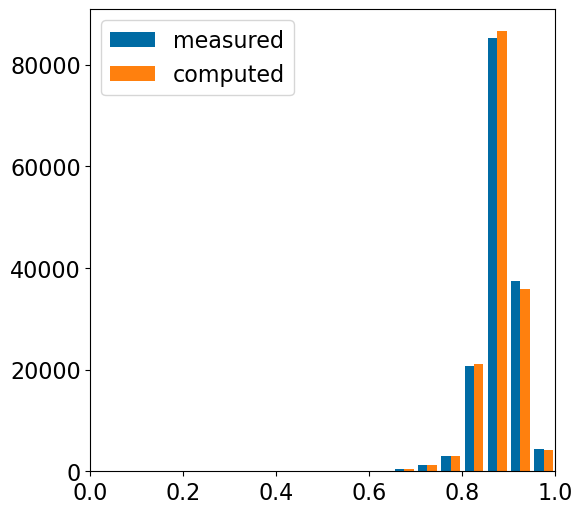

In [10]:
nAts = [x.GetNumHeavyAtoms() for x in mols]
psims = []
for x in nAts:
    if x<=1:
        continue
    psims.extend([(x*(x-1)/2 - (x-1))/(x*(x-1)/2 + (x-1))]*x)

plt.figure(figsize=(6,6))
plt.hist([[y for x,y in ap_accum['counts'][3]],psims],label=['measured','computed'],bins=20);
plt.xlim(0,1);
plt.legend();

# Visualizing the impact of single-atom changes on similarity

Using the RDKit's [similarity maps](https://doi.org/10.1186/1758-2946-5-43) we can directly visualize how much the single-atom changes affect similarity


In [165]:
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import rdDepictor
from PIL import Image
from io import BytesIO


def draw_similarity_map(m,fpfunc,scale_vals=False,fillIt=True,sigma=0.45,w=500,h=300):
    basefp = fpfunc(m)
    diffs = []
    for aidx in range(m.GetNumAtoms()):
        nm = Chem.Mol(m)
        nm.GetAtomWithIdx(aidx).SetAtomicNum(0)
        nfp = fpfunc(nm)
        sim = DataStructs.TanimotoSimilarity(basefp,nfp)
        diffs.append(1.-sim)


    diffs = np.array(diffs)
    rng = max(diffs)-min(diffs)
    
    # print out the max and min changes caused by a single atom
    print(f'  max diff={max(diffs):.2f} min diff={min(diffs):.2f}')
    
    # optionally scale the values so that differences are more visible
    if scale_vals:
        diffs = (diffs - min(diffs))/rng + 0.1
        
        
    d2d = Draw.MolDraw2DCairo(w,h)
    d2d.drawOptions().useBWAtomPalette()

    ps = Draw.ContourParams()
    ps.fillGrid = fillIt
    ps.gridResolution = 0.1
    ps.extraGridPadding = 0.5

    m = rdMolDraw2D.PrepareMolForDrawing(m, addChiralHs=False)
    if not m.GetNumConformers():
      rdDepictor.Compute2DCoords(m)
    sigmas = [sigma] * m.GetNumAtoms()
    locs = []
    for i in range(m.GetNumAtoms()):
      p = m.GetConformer().GetAtomPosition(i)
      locs.append(Geometry.Point2D(p.x, p.y))

    Draw.ContourAndDrawGaussians(d2d, locs, list(diffs), sigmas, nContours=8, params=ps)
    d2d.drawOptions().clearBackground = False
    d2d.DrawMolecule(m)
    
    d2d.FinishDrawing()

    sio = BytesIO(d2d.GetDrawingText())
    return Image.open(sio)


  max diff=0.19 min diff=0.12


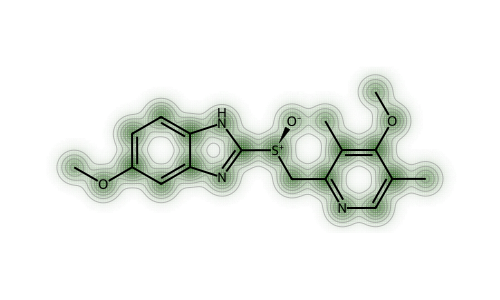

In [166]:
fpg = rdFingerprintGenerator.GetMorganGenerator(radius=1,fpSize=2048)
draw_similarity_map(esomeprazole,fpg.GetCountFingerprint)

  max diff=0.43 min diff=0.17


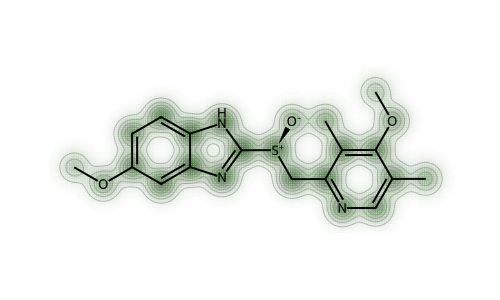

In [173]:
fpg = rdFingerprintGenerator.GetMorganGenerator(radius=3,fpSize=2048)
draw_similarity_map(esomeprazole,fpg.GetCountFingerprint)

What about the RDKit fingerprint?

  max diff=0.50 min diff=0.06


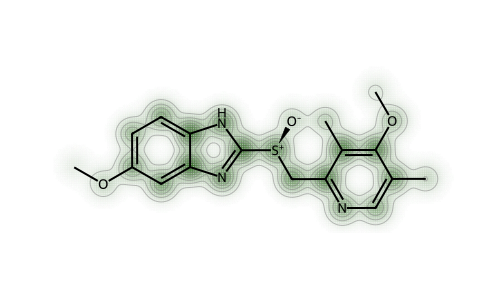

In [174]:
fpg = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5,fpSize=2048)
draw_similarity_map(esomeprazole,fpg.GetCountFingerprint)

This makes it look like centrality is important - the changes are largest around the central S atom. That's a bit misleading, as another molecule will show.

Let's look at a molecule from the set that we've been working with.

Morgan fingerprint:

  max diff=0.47 min diff=0.21


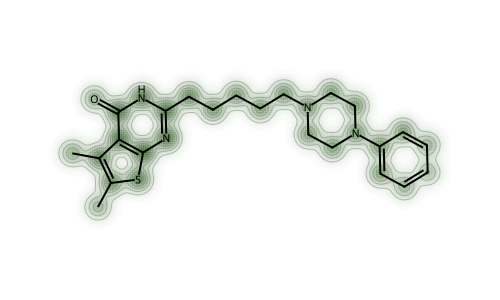

In [181]:
fpg = rdFingerprintGenerator.GetMorganGenerator(radius=3,fpSize=2048)
draw_similarity_map(mols[4],fpg.GetFingerprint)

And RDKit fingerprint:

  max diff=0.60 min diff=0.08


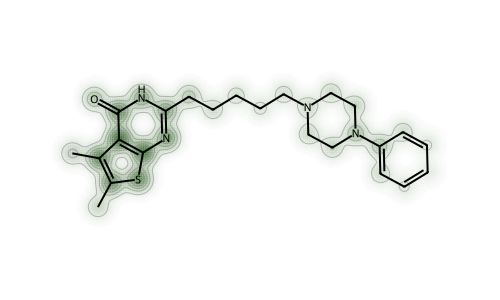

In [177]:
fpg = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5,fpSize=2048)
draw_similarity_map(mols[4],fpg.GetFingerprint)

With both fingerprints (but particularly the RDKit fingerprint), we can see that the perturbations are largest in the "topologically complex" parts of the molecule: areas with a lot of branching.

# Looking at $\Delta_{similarity}$ as a function of the number of atoms in the neighborhood

My original idea with this post was to look at how much of an impact "centrality" - how close an atom is to the middle of the molecule - has on similarity. I realized pretty quickly that the important factor for more "local" fingerprints is the number of atoms within the fingerprints "radius", not necessarily where that atom is in the molecule.

So let's look at that.

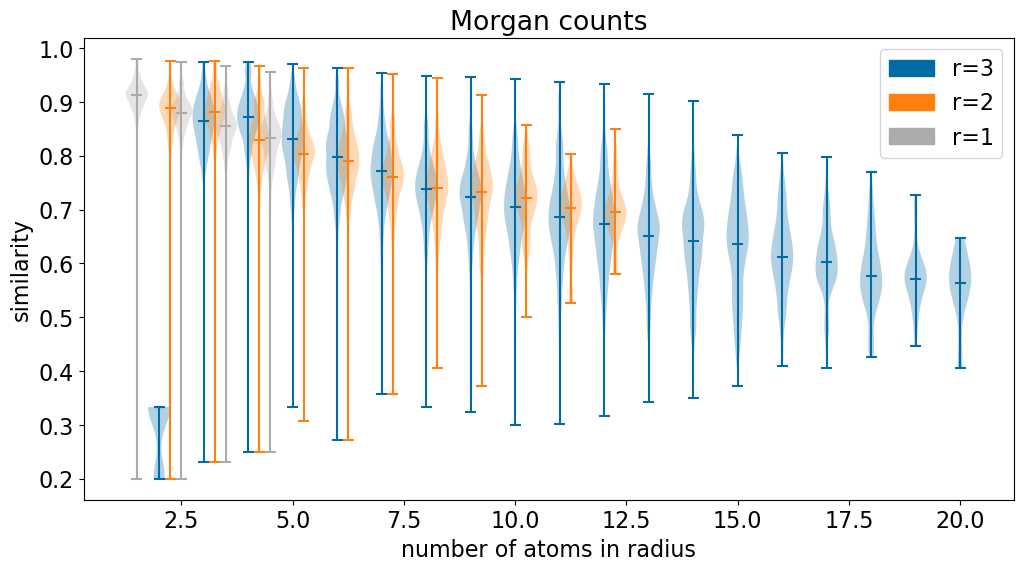

In [163]:

import matplotlib.patches as mpatches
plt.figure(figsize=(12,6))

labels = []
for i,rad in enumerate((3,2,1)):
    d = defaultdict(list)
    for r,s in accum['counts'][rad]:
        d[r-1].append(s)
    labels.append((mpatches.Patch(color=f'C{i}'), f'r={rad}'))
    
    # only keep cases where we have at least 10 examples
    for k in list(d.keys()):
        if len(d[k])<10:
            del d[k]
        ks = sorted(d.keys())

    ps = [x+i*.25 for x in ks]
    plt.violinplot([d[k] for k in ks],ps,showmedians=True)

    plt.xlabel('number of atoms in radius')
plt.ylabel('similarity')
plt.legend(*zip(*labels))
plt.title('Morgan counts');

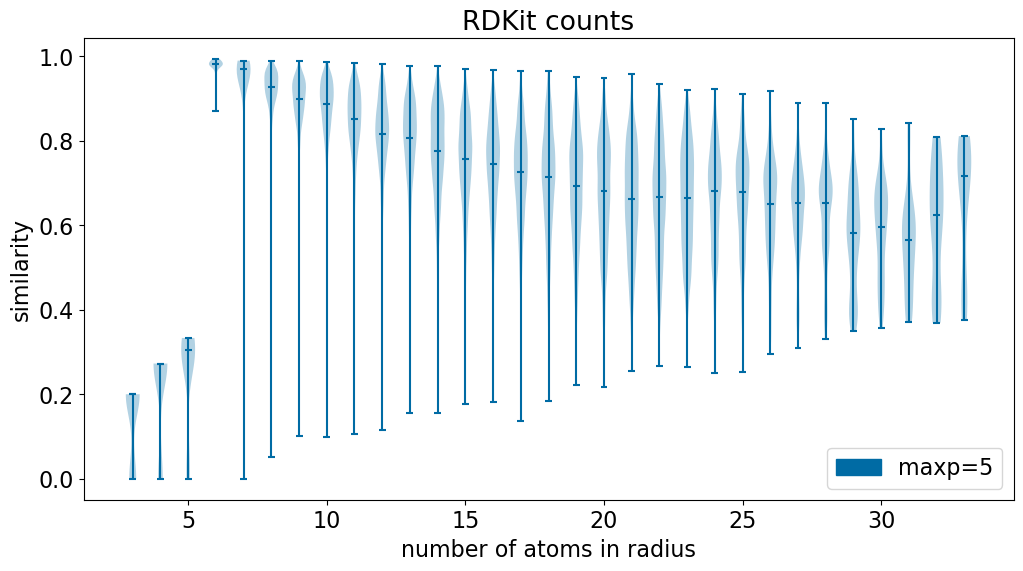

In [162]:
import matplotlib.patches as mpatches
plt.figure(figsize=(12,6))

labels = []
for i,rad in enumerate((5,)):
    d = defaultdict(list)
    for r,s in rdkit_accum['counts'][rad]:
        d[r].append(s)
    labels.append((mpatches.Patch(color=f'C{i}'), f'maxp={rad}'))

    # only keep cases where we have at least 10 examples
    for k in list(d.keys()):
        if len(d[k])<10:
            del d[k]
    
    ks = sorted(d.keys())
    ps = [x+i*.25 for x in ks]
    plt.violinplot([d[k] for k in ks],ps,showmedians=True)

plt.xlabel('number of atoms in radius')
plt.ylabel('similarity')
plt.legend(*zip(*labels),loc=4)
plt.title('RDKit counts');

The similarity initially decreases before flattening out at around 20 atoms in the radius.